# Convolutional Variational Autoencoder

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import sys,os,glob
sys.path.append('../util/')
from util import plotProgress

from keras.datasets import mnist
from keras.layers import Dense, Input, LeakyReLU
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

from tensorflow import set_random_seed
set_random_seed(2) #reproducibility

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))
K.get_session().run(tf.global_variables_initializer())

Using TensorFlow backend.


## Load Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


## Declare Parameters

In [3]:
epochs = 100
batch = 256
latent_dim = 2
inters = [1000,256,32]
optimizer = 'adam'
filters = [8,16]
kernel_size = 3
rate_recon = 0.9999999

In [4]:
def sampling(args):
    z_mean,z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0],latent_dim),mean = 0,stddev = 1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [5]:
def lossVAE(z_mean, z_sigma_log):
    def loss(tensor_input, tensor_decode):
        loss_recon =  metrics.binary_crossentropy(K.flatten(tensor_input), K.flatten(tensor_decode))
        loss_KL = - 0.5 * K.sum(1 + z_sigma_log - K.square(z_mean) - K.exp(z_sigma_log), axis = -1)
        return rate_recon * loss_recon + (1-rate_recon) * loss_KL
    return loss

In [6]:
#Build Encoder
input_img = Input(shape = X_train.shape[1:])
x = input_img
for fil in filters:
    x = Conv2D(filters = fil,
             kernel_size = kernel_size,
             activation = 'relu',
             padding = 'same',
             strides = 1)(x)
shape = K.int_shape(x)
x = Flatten()(x)

for inter in inters:
    x = Dense(inter,activation = 'relu')(x)
    
z_mean = Dense(latent_dim,activation = 'linear')(x)
z_log_var = Dense(latent_dim,activation = 'linear')(x)

encoder = Model(input_img,z_mean)
encoder.summary()

# Sampling
z = Lambda(sampling,output_shape = (latent_dim,))([z_mean,z_log_var])

# Build Decoder
latent = Input(shape = (latent_dim,))
x = latent
for inter in inters[::-1]:
    x = Dense(inter,activation = 'relu')(x)
x = Dense(shape[1] * shape[2] * shape[3],activation = 'relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for fil in filters[::-1]:
    x = Conv2DTranspose(filters = fil,
                      kernel_size = kernel_size,
                      activation = 'relu',
                      strides = 1,
                      padding = 'same')(x)
    
outputs = Conv2DTranspose(filters = 1,
                        kernel_size = kernel_size,
                        activation = 'sigmoid',
                        padding = 'same')(x)

decoder = Model(latent,outputs)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              12545000  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               256256    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
__________

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.2491 - val_loss: 0.2145
Epoch 2/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.2036 - val_loss: 0.1957
Epoch 3/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.1906 - val_loss: 0.1876
Epoch 4/100
60000/60000 [==============================] - 5s 77us/step - loss: 0.1841 - val_loss: 0.1816
Epoch 5/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.1799 - val_loss: 0.1792
Epoch 6/100
60000/60000 [==============================] - 5s 77us/step - loss: 0.1770 - val_loss: 0.1769
Epoch 7/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.1748 - val_loss: 0.1748
Epoch 8/100
60000/60000 [==============================] - 5s 77us/step - loss: 0.1731 - val_loss: 0.1733
Epoch 9/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.1713 - val_loss: 0.

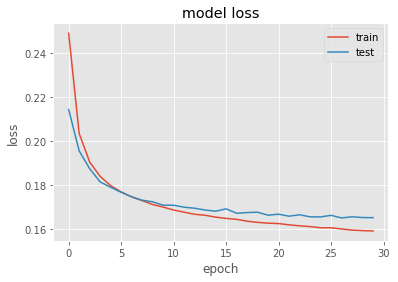

In [7]:
autoencoder = Model(input_img,decoder(z))
autoencoder.compile(optimizer = optimizer,loss = lossVAE(z_mean,z_log_var))
es_cb = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'auto')
history = autoencoder.fit(X_train, X_train,
                epochs = epochs,
                batch_size = batch,
                shuffle = True,
                callbacks = [es_cb],
                validation_data = (X_test,X_test))
plotProgress(history)

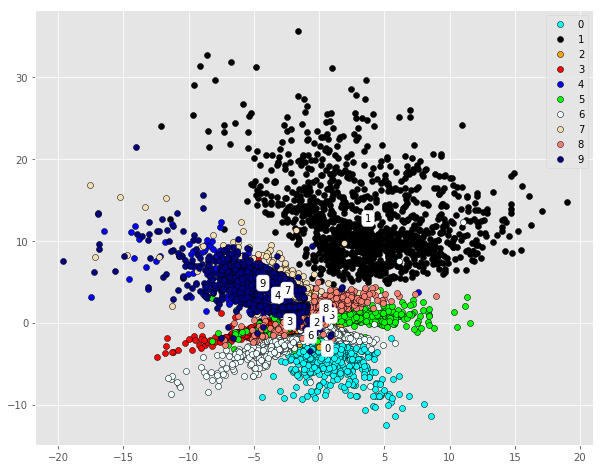

In [8]:
pred = encoder.predict(X_test)
cmap = ['cyan','black','orange','red','blue','lime','azure','wheat','salmon','navy']
fig,ax = plt.subplots(figsize = (10,8))
for i in range(10):
    ax.scatter(pred[y_test == i,0],pred[y_test == i,1],
                edgecolors = 'black',
                c = cmap[i],
                label = str(i))
    ax.annotate(str(i),(pred[y_test == i,0].mean(),pred[y_test == i,1].mean()),
               bbox = dict(boxstyle = "round", fc = "w"))
plt.legend()
fig.savefig('images/clusters_8_16-256-32',bbox_inches='tight')

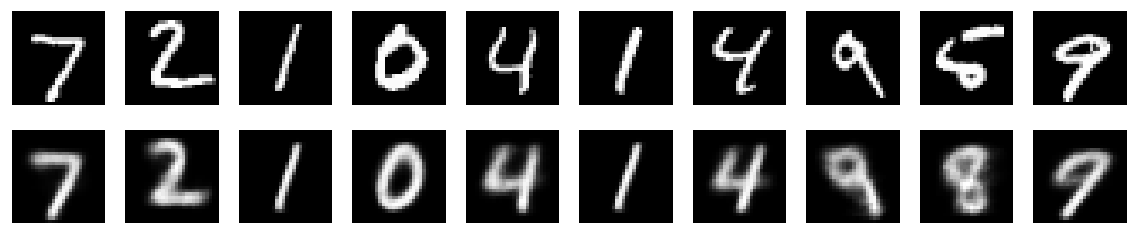

In [9]:
# get decoded digits
reconstructed = decoder.predict(pred)
# plot decoded
n = 10
row = 0
fig = plt.figure(figsize = (20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i + row * n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i + row * n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig.savefig('images/digits_8_16-256-32',bbox_inches='tight')